In [ ]:
TF_ENABLE_ONEDNN_OPTS=0

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, MaxPooling2D, Input, Dropout
from tensorflow.keras import Model, Sequential
from tensorflow.keras.utils import plot_model
import os
from imutils import paths
import glob
import numpy as np
import cv2
from sklearn import preprocessing
from keras.utils import to_categorical
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
import itertools

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
base_dir = '/content/drive/MyDrive/Master Computer Science Instruction/COMP SCI 7318 - Deep Learning Fundametal/AS2/'
def get_dir_path(file_location, dirname):
  root_directory = os.path.dirname(file_location)
  return os.path.join(root_directory, dirname)
data_path = get_dir_path(base_dir, 'fire_dataset')
#Make list of class: non_fire and fire
classNames = np.array(sorted(os.listdir(os.path.join(data_path,'train'))))
image_size = 224

train_images = []
train_labels = []
for dir_path in glob.glob(data_path + '/train/*'):
  label = dir_path.split('/')[-1]
  for img_path in glob.glob(os.path.join(dir_path, '*.png')):
    img = cv2.imread(img_path, cv2.IMREAD_COLOR)
    if img is None:
      continue
    img = cv2.resize(img, (image_size, image_size))
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    train_images.append(img)
    train_labels.append(label)
train_images = np.array(train_images)
train_labels = np.array(train_labels)

In [ ]:
test_images = []
test_labels = []
for dir_path in glob.glob(data_path + '/test/*'):
  label = dir_path.split('/')[-1]
  for img_path in glob.glob(os.path.join(dir_path, '*.png')):
    img = cv2.imread(img_path, cv2.IMREAD_COLOR)
    if img is None:
      continue
    img = cv2.resize(img, (image_size, image_size))
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    test_images.append(img)
    test_labels.append(label)
test_images = np.array(test_images)
test_labels = np.array(test_labels)

In [ ]:
le = preprocessing.LabelEncoder()
le.fit(test_labels)
test_labels_encoded = le.transform(test_labels)
le.fit(train_labels)
train_labels_encoded = le.transform(train_labels)

In [ ]:
x_train, y_train, x_test, y_test = train_images, train_labels_encoded, test_images, test_labels_encoded
x_train, x_test = x_train / 255.0, x_test / 255.0

In [ ]:
y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)

In [ ]:
from keras.applications.inception_v3 import InceptionV3
trained_model = tf.keras.applications.InceptionV3(input_shape = (image_size, image_size, 3),include_top=False, weights='imagenet')

In [ ]:
for layer in trained_model.layers:
  layer.trainable = False

last_layer = trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 12, 12, 768)


In [ ]:
train_feature_extractor = trained_model.predict(x_train)
train_features = train_feature_extractor.reshape(train_feature_extractor.shape[0], -1)
test_feature_extractor = trained_model.predict(x_test)
test_features = test_feature_extractor.reshape(test_feature_extractor.shape[0], -1)

32/32 [==============================] - 183s 6s/step


In [ ]:
#PCA to reduce the dimensions
#Verify ideal number of PCA components to not lose much information
#n_components must < rows * columns (features)
pca_test = PCA(n_components=300)
pca_test.fit(train_features)

PCA(n_components=300)

Text(0, 0.5, 'Cum variance')

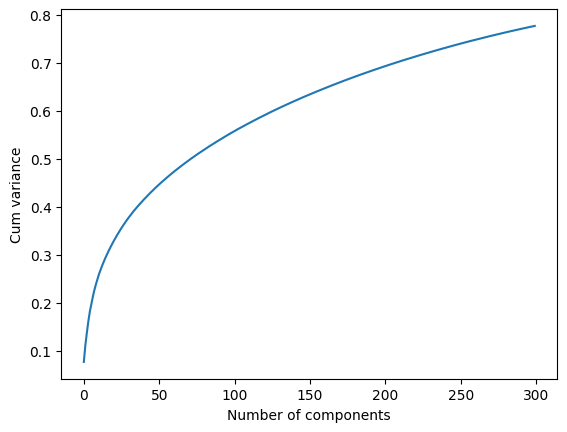

In [ ]:
# Test out the efficiency pca test
plt.plot(np.cumsum(pca_test.explained_variance_ratio_))
plt.xlabel("Number of components")
plt.ylabel("Cum variance")

In [ ]:
# From the graph, we see the n_components = 300 -> Cum_variance got a high precision
n_PCA_components = 300
pca = PCA(n_components=n_PCA_components)

In [ ]:
train_PCA = pca.fit_transform(train_features)
test_PCA = pca.fit_transform(test_features)

In [ ]:
model_dir = get_dir_path(base_dir, 'saved_model')
model_h5_path = os.path.join(model_dir, 'model.h5')
model_h5_weight = os.path.join(model_dir, "model_weight.h5")

In [ ]:
if not os.path.exists(model_h5_path):
  model = Sequential()
  inputs = Input(shape=(n_PCA_components))
  hidden = Dense(256, activation='relu')(inputs)
  output = Dense(2, activation='sigmoid')(hidden)

  model = Model(inputs=inputs, outputs=output)

  model.compile(optimizer = RMSprop(learning_rate=0.0001),
                loss = 'binary_crossentropy',
                metrics = ['accuracy'])
else:
  model = load_model(model_h5_path)
  if os.path.exists(model_h5_weight):
    model.load_weights(model_h5_weight)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 300)]             0         
                                                                 
 dense (Dense)               (None, 256)               77056     
                                                                 
 dense_1 (Dense)             (None, 2)                 514       
                                                                 
Total params: 77570 (303.01 KB)
Trainable params: 77570 (303.01 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
history = model.fit(train_PCA,
          y_train_one_hot,
          steps_per_epoch=len(train_images),
          epochs=50,
          verbose=1)

Epoch 1/50
998/998 [==============================] - 4s 3ms/step - loss: 0.8349 - accuracy: 0.8537
Epoch 2/50
998/998 [==============================] - 3s 3ms/step - loss: 0.1859 - accuracy: 0.9619
Epoch 3/50
998/998 [==============================] - 3s 3ms/step - loss: 0.0745 - accuracy: 0.9850
Epoch 4/50
998/998 [==============================] - 3s 3ms/step - loss: 0.0367 - accuracy: 0.9940
Epoch 5/50
998/998 [==============================] - 4s 4ms/step - loss: 0.0214 - accuracy: 0.9940
Epoch 6/50
998/998 [==============================] - 7s 7ms/step - loss: 0.0150 - accuracy: 0.9960
Epoch 7/50
998/998 [==============================] - 4s 4ms/step - loss: 0.0075 - accuracy: 0.9970
Epoch 8/50
998/998 [==============================] - 4s 4ms/step - loss: 0.0046 - accuracy: 0.9980
Epoch 9/50
998/998 [==============================] - 4s 4ms/step - loss: 0.0012 - accuracy: 0.9990
Epoch 10/50
998/998 [==============================] - 4s 4ms/step - loss: 1.9501e-04 - accuracy: 1.

In [ ]:
model.save_weights(model_h5_weight)
print("Saved Successful")

Saved Successful


Text(0.5, 1.0, 'Training loss')

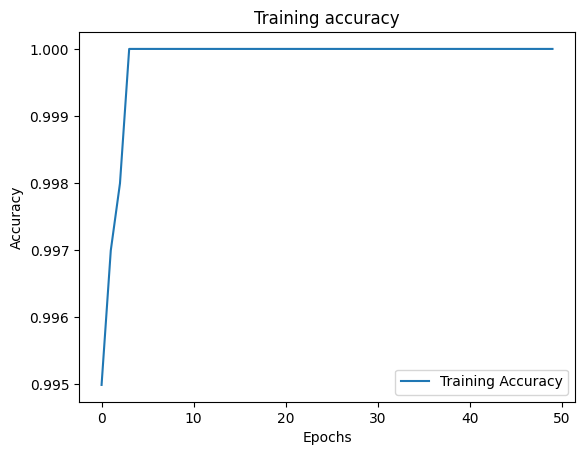

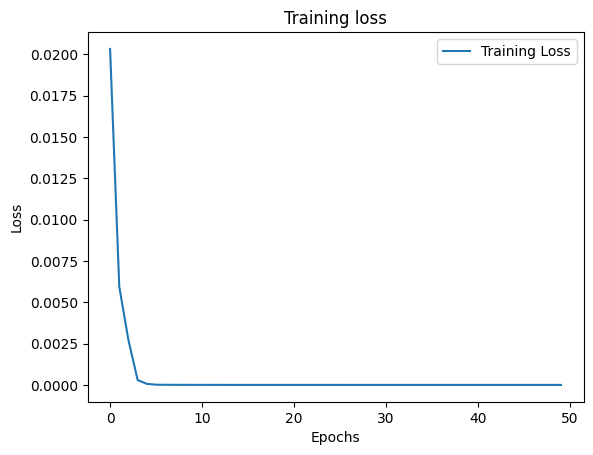

In [ ]:
acc      = history.history[     'accuracy' ]
loss     = history.history[    'loss' ]
epochs   = range(len(acc))

plt.figure(1)
plt.plot  ( epochs,     acc )
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend( ["Training Accuracy"])
plt.title ('Training accuracy')
plt.figure(2)
plt.plot  ( epochs,     loss )
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend( ["Training Loss"])
plt.title ('Training loss'   )

In [ ]:
def plot_confusion_matrix(cm,classes,normalize=False,title='Confusion Matrix',cmap=plt.cm.Blues):
  plt.imshow(cm,interpolation='nearest',cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks,classes,rotation=45)
  plt.yticks(tick_marks,classes)

  if normalize:
    cm = cm.astype('float') / cm.sum(axis = 1)[:,np.newaxis]
    print("Normalized confusion matrix")
  else:
    print("Confusion matrix, without normalization")
  print(cm)

  thresh = cm.max() / 2
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j,i, cm[i,j],horizontalalignment="center",color="white" if cm[i,j] > thresh else "black")

In [ ]:
y_pred = model.predict(test_PCA)
y_pred = np.argmax(y_pred, axis=1)
y_pred = le.inverse_transform(y_pred)

predict = []
for i in range(len(y_pred)):
  if y_pred[i] == 'fire_images':
    predict.append(1)
  else:
    predict.append(0)

32/32 [==============================] - 0s 2ms/step


In [ ]:
x_pred = model.predict(train_PCA)
x_pred = np.argmax(x_pred, axis=1)
x_pred = le.inverse_transform(x_pred)

predict_train = []
for i in range(len(x_pred)):
  if x_pred[i] == 'fire_images':
    predict_train.append(1)
  else:
    predict_train.append(0)

32/32 [==============================] - 0s 4ms/step


In [ ]:
cm = confusion_matrix(test_labels_encoded, predict)

Confusion matrix, without normalization
[[  6 749]
 [237   6]]


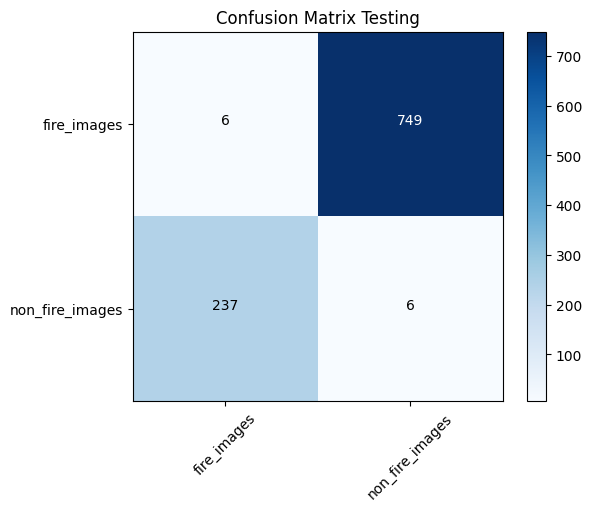

In [ ]:
plot_confusion_matrix(cm = cm, classes=classNames, title='Confusion Matrix Testing')

In [ ]:
cm = confusion_matrix(train_labels_encoded, predict_train)

Confusion matrix, without normalization
[[  0 755]
 [243   0]]


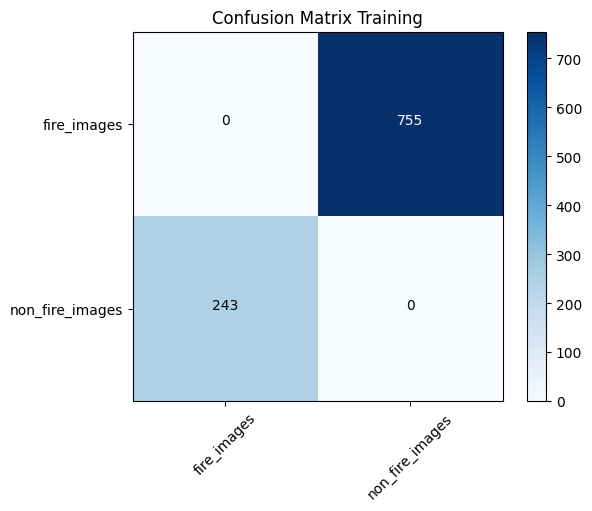

In [ ]:
plot_confusion_matrix(cm = cm, classes=classNames, title='Confusion Matrix Training')

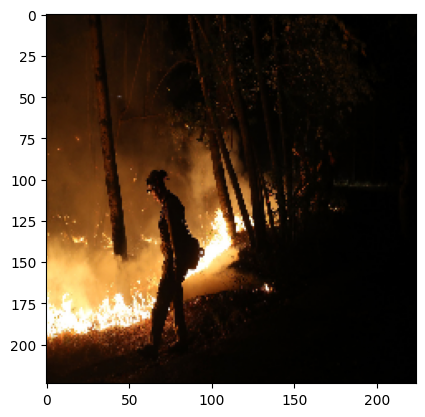

In [ ]:
n = np.random.randint(0, x_test.shape[0])
img = x_test[n]
plt.imshow(img)

In [ ]:
input_img = np.expand_dims(img, axis=0)
input_img_feature=trained_model.predict(input_img)
input_img_features = input_img_feature.reshape(input_img_feature.shape[0], -1)
input_img_PCA = pca.transform(input_img_features)
prediction_img = model.predict(input_img_PCA)
prediction_img = np.argmax(prediction_img, axis = 1)
prediction_img = le.inverse_transform(prediction_img)
print("Prediction: ", prediction_img)
print("Actual: ", test_labels[n])

1/1 [==============================] - 0s 101ms/step
Prediction:  ['fire_images']
Actual:  fire_images


In [ ]:
model_dir = get_dir_path(base_dir, 'saved_model')
model.save(os.path.join(model_dir, 'model.h5'))

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
